In [1]:
import DiadFit as pf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
from scipy.optimize import newton

In [2]:
## This function helps find co2 density at a given depth, based on crust density model, EOS, XH2O and T

def find_co2_density_for_depth(T_K, desired_depth_km=4.0, initial_CO2_dens_gcm3=0.2,  crust_dens_kgm3=2300,XH2O=None,EOS='SW96',tolerance=0.001):

    # Define the function to minimize (the difference between desired_depth_km and the actual depth)
    def depth_difference(co2_dens_gcm3):
        result_df = pf.convert_co2_dens_press_depth(XH2O=XH2O,EOS=EOS, CO2_dens_gcm3=co2_dens_gcm3, T_K=T_K, crust_dens_kgm3=crust_dens_kgm3)
        current_depth_km = result_df.loc[0, 'Depth (km)']
        return current_depth_km - desired_depth_km

    # Use newton to find the root of depth_difference
    result = newton(depth_difference, x0=initial_CO2_dens_gcm3, tol=tolerance)

    return result

# this function to find pressure at a given depth based on crustal model alone

def find_pressure_for_depth(desired_depth_km, crust_dens_kgm3=2300, initial_P_kbar=0.903, tolerance=0.0001):

    # Define the function to minimize (the difference between desired_depth_km and the actual depth)
    def depth_difference(P_kbar):
        result_depth_km = pf.convert_pressure_to_depth(P_kbar, crust_dens_kgm3)[0]
        return result_depth_km - desired_depth_km

    # Use newton to find the root of depth_difference
    result = newton(depth_difference, x0=initial_P_kbar, tol=tolerance)

    return result


def find_CO2_density_for_pressure(desired_pressure, T_K, XH2O, initial_guess=0.01, tolerance=0.0001):

    # Define the function to minimize (the difference between desired_pressure and the actual pressure)
    def pressure_difference(CO2_dens_gcm3):
        result_pressure = pf.calculate_entrapment_P_XH2O(CO2_dens_gcm3=CO2_dens_gcm3, T_K=T_K, XH2O=XH2O)['P_kbar_mixCO2_DZ06_Hloss'][0]
        return result_pressure - desired_pressure

    # Use newton to find the root of pressure_difference
    result = newton(pressure_difference, x0=initial_guess, tol=tolerance)

    return result



# Set temperatures for calculations
- We assumed initially a temp of 1150 C (prior to SEM data)
- The mean and median SEM-EDS measured Temp based on Fo content of hosts for the Sept 10th eruption was 1238 C (rounded up to 1240C)
- The whole range of measured temperatures for ol-saturated liquids ever erupted in Kilauea's history is 1100 - 1350 C (DeVitre and Wieser, 2024 GPL). Temp error in MonteCarlo simulations is based on this range: 125C = (1350-1100)/2 

In [3]:
median_meas_T_K=1240+273.15 # this is the average SEM-EDS measured Temp based on FO for the Sept 10th eruption
assumed_T_K=1150+273.15 # Our initial guess based on past eruption history

T=[1100,1150,1240,1350] # Whole range of T for ol-saturated liquids ever erupted in Kilauea history 
T_K=[t+273.15 for t in T]


## Calculate Pressures and Depths for the whole range of T and for CO2 densities between 0 and 1.5 g/cm3

In [4]:
rhos=np.linspace(0.001,1.4,1000) # set range of densities for plotting later

P_values_XH2O10p_DZ06_full = [pf.calculate_entrapment_P_XH2O(CO2_dens_gcm3=rhos,T_K=T_K[i],XH2O=0.1) for i in range(len(T_K))] # Calculate P for range of CO2 densities, this returns both pure CO2 EOS and DZ06 XH2O=0.1


# separate Pure SW96 results same as doing this [pf.calculate_P_for_rho_T(CO2_dens_gcm3=rhos,T_K=T_K[i],EOS='SW96') for i in range(len(T_K))]
P_values_SW96 = [df[['P_kbar_pureCO2_SW96', 'CO2_dens_gcm3', 'T_K']]
                 .rename(columns={'P_kbar_pureCO2_SW96': 'P_kbar'})
                 .assign(**{'Pressure (MPa)': df['P_kbar_pureCO2_SW96'] * 100})
                 .reindex(columns=['P_kbar', 'Pressure (MPa)', 'CO2_dens_gcm3', 'T_K']) 
                 .assign(**{'Depth (km)': pf.convert_pressure_to_depth(P_kbar=df['P_kbar_pureCO2_SW96'], crust_dens_kgm3=2300)})
                 for df in P_values_XH2O10p_DZ06_full] 

# separate Pure SP94 results same as doing this [pf.calculate_P_for_rho_T(CO2_dens_gcm3=rhos,T_K=T_K[i],EOS='SP94') for i in range(len(T_K))]
P_values_SP94 = [df[['P_kbar_pureCO2_SP94', 'CO2_dens_gcm3', 'T_K']]
                 .rename(columns={'P_kbar_pureCO2_SP94': 'P_kbar'})
                 .assign(**{'Pressure (MPa)': df['P_kbar_pureCO2_SP94'] * 100})
                 .reindex(columns=['P_kbar', 'Pressure (MPa)', 'CO2_dens_gcm3', 'T_K']) 
                 .assign(**{'Depth (km)': pf.convert_pressure_to_depth(P_kbar=df['P_kbar_pureCO2_SP94'], crust_dens_kgm3=2300)})
                 for df in P_values_XH2O10p_DZ06_full]

# separate the mixed H2O-CO2 results, we assume H is lost as this is most likely what's measured with real samples.
P_values_DZ06 = [df[['P_kbar_mixCO2_DZ06_Hloss', 'CO2_dens_gcm3', 'T_K','XH2O']]
                                .rename(columns={'P_kbar_mixCO2_DZ06_Hloss': 'P_kbar'})
                                .assign(**{'Pressure (MPa)': df['P_kbar_mixCO2_DZ06_Hloss'] * 100})
                                .reindex(columns=['P_kbar', 'Pressure (MPa)', 'CO2_dens_gcm3', 'T_K']) 
                                .assign(**{'Depth (km)': pf.convert_pressure_to_depth(P_kbar=df['P_kbar_mixCO2_DZ06_Hloss'], crust_dens_kgm3=2300)})
                                for df in P_values_XH2O10p_DZ06_full] 

## Now let's calculate conditions and MonteCarlo temperature uncertainty on the theoretical FI

In [5]:
# Now calculate P and CO2 density for 2 theoretical FI trapped at HM (1.5 km) and SC (4 km) reservoirs

P_MPa_at4km=find_pressure_for_depth(desired_depth_km=4)*100 # The pressure at 4km depth based only on crustal density model
P_MPa_at1km=find_pressure_for_depth(desired_depth_km=1.5)*100 # The pressure at 1.5km depth based only on crustal density model

co2_dens_1km_pure_SW96=pf.calculate_rho_for_P_T(EOS='SW96',P_kbar=P_MPa_at1km/100,T_K=assumed_T_K)[0]
co2_dens_4km_pure_SW96=pf.calculate_rho_for_P_T(EOS='SW96',P_kbar=P_MPa_at4km/100,T_K=assumed_T_K)[0]

co2_dens_1km_pure_SP94=pf.calculate_rho_for_P_T(EOS='SP94',P_kbar=P_MPa_at1km/100,T_K=assumed_T_K)[0]
co2_dens_4km_pure_SP94=pf.calculate_rho_for_P_T(EOS='SP94',P_kbar=P_MPa_at4km/100,T_K=assumed_T_K)[0]

## For Duan and Zhang, we assume that H has been lost (as this is likely the CO2 density we are measuring), so this newton converges on P_kbar_Hloss
co2_dens_1km_XH2O10p_DZ06=find_CO2_density_for_pressure(desired_pressure=P_MPa_at1km/100, T_K=assumed_T_K, XH2O=0.1)
co2_dens_4km_XH2O10p_DZ06=find_CO2_density_for_pressure(desired_pressure=P_MPa_at4km/100, T_K=assumed_T_K, XH2O=0.1)

####### Monte Carlo ############

MC_P_starFI_SW96=pf.propagate_FI_uncertainty(T_K=assumed_T_K,
error_T_K=(T_K[T_K.index(max(T_K))]-T_K[T_K.index(min(T_K))])/2, error_type_T_K='Abs', error_dist_T_K='normal',
                        CO2_dens_gcm3=pd.Series([co2_dens_1km_pure_SW96,co2_dens_4km_pure_SW96]),
                        sample_ID=pd.Series(['HM_FI','SC_FI']),
                        crust_dens_kgm3=2300,
                        EOS='SW96',
                        N_dup=1000, fig_i=0, plot_figure=False)[0]

MC_P_starFI_SP94=pf.propagate_FI_uncertainty(T_K=assumed_T_K,
error_T_K=(T_K[T_K.index(max(T_K))]-T_K[T_K.index(min(T_K))])/2, error_type_T_K='Abs', error_dist_T_K='normal',
                        CO2_dens_gcm3=pd.Series([co2_dens_1km_pure_SP94,co2_dens_4km_pure_SP94]),
                        sample_ID=pd.Series(['HM_FI','SC_FI']),
                        crust_dens_kgm3=2300,
                        EOS='SP94',
                        N_dup=1000, fig_i=0, plot_figure=False)[0]

MC_P_starFI_DZ06=pf.propagate_FI_uncertainty(T_K=assumed_T_K,
error_T_K=(T_K[T_K.index(max(T_K))]-T_K[T_K.index(min(T_K))])/2, error_type_T_K='Abs', error_dist_T_K='normal',
                        CO2_dens_gcm3=pd.Series([co2_dens_1km_XH2O10p_DZ06,co2_dens_4km_XH2O10p_DZ06]),
                        sample_ID=pd.Series(['HM_FI','SC_FI']),
                        crust_dens_kgm3=2300,
                        XH2O=0.1,
                        N_dup=1000, fig_i=0, plot_figure=False)[0]

display(MC_P_starFI_SW96)
display(MC_P_starFI_SP94)
display(MC_P_starFI_DZ06)

working on sample number 0
working on sample number 0
You have entered a value for XH2O, so we are now using the EOS of Duan and Zhang 2006. If you dont want this, specify XH2O=None
Please note, the DZ2006 EOS is about 5-40X slower to run than the SP94 and SW94 EOS
working on sample number 0


,Filename,CO2_dens_gcm3,SingleFI_D_km,SingleFI_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,std_dev_MC_P_kbar_from_percentile,Mean_MC_D_km,Med_MC_D_km,std_dev_MC_D_km,std_dev_MC_D_km_from_percentile,error_T_K,error_CO2_dens_gcm3,error_crust_dens_kgm3,T_K,CO2_dens_gcm3_input,model,crust_dens_kgm3,EOS
0,HM_FI,0.116377,1.5,0.338445,0.339253,0.339274,0.031087,0.030668,1.503582,1.503675,0.137778,0.135921,125.0,0,0.0,1423.15,0.116377,None,2300,SW96
1,SC_FI,0.273254,4.0,0.902520,0.894112,0.892218,0.092164,0.090226,3.962733,3.954343,0.408476,0.399886,125.0,0,0.0,1423.15,0.273254,None,2300,SW96


,Filename,CO2_dens_gcm3,SingleFI_D_km,SingleFI_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,std_dev_MC_P_kbar_from_percentile,Mean_MC_D_km,Med_MC_D_km,std_dev_MC_D_km,std_dev_MC_D_km_from_percentile,error_T_K,error_CO2_dens_gcm3,error_crust_dens_kgm3,T_K,CO2_dens_gcm3_input,model,crust_dens_kgm3,EOS
0,HM_FI,0.116857,1.5,0.338445,0.339461,0.338817,0.031589,0.031132,1.504504,1.501648,0.140005,0.137977,125.0,0,0.0,1423.15,0.116857,None,2300,SP94
1,SC_FI,0.271329,4.0,0.902520,0.893755,0.893508,0.084559,0.083724,3.961155,3.960060,0.374767,0.371066,125.0,0,0.0,1423.15,0.271329,None,2300,SP94


,Filename,CO2_dens_gcm3,SingleFI_D_km,SingleFI_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,std_dev_MC_P_kbar_from_percentile,Mean_MC_D_km,Med_MC_D_km,...,error_CO2_dens_gcm3,error_crust_dens_kgm3,T_K,CO2_dens_gcm3_input,model,crust_dens_kgm3,EOS,error_XH2O,error_type_XH2O,error_dist_XH2O
0,HM_FI,0.105888,1.5,0.338445,0.337340,0.337182,0.030555,0.029197,1.495104,1.494400,...,0,0.0,1423.15,0.105888,None,2300,SW96,0,Abs,normal
1,SC_FI,0.249757,4.0,0.902520,0.907004,0.911675,0.089793,0.090968,4.019875,4.040577,...,0,0.0,1423.15,0.249757,None,2300,SW96,0,Abs,normal


## Pure CO2 Span and Wagner 96 temperature sensitivity

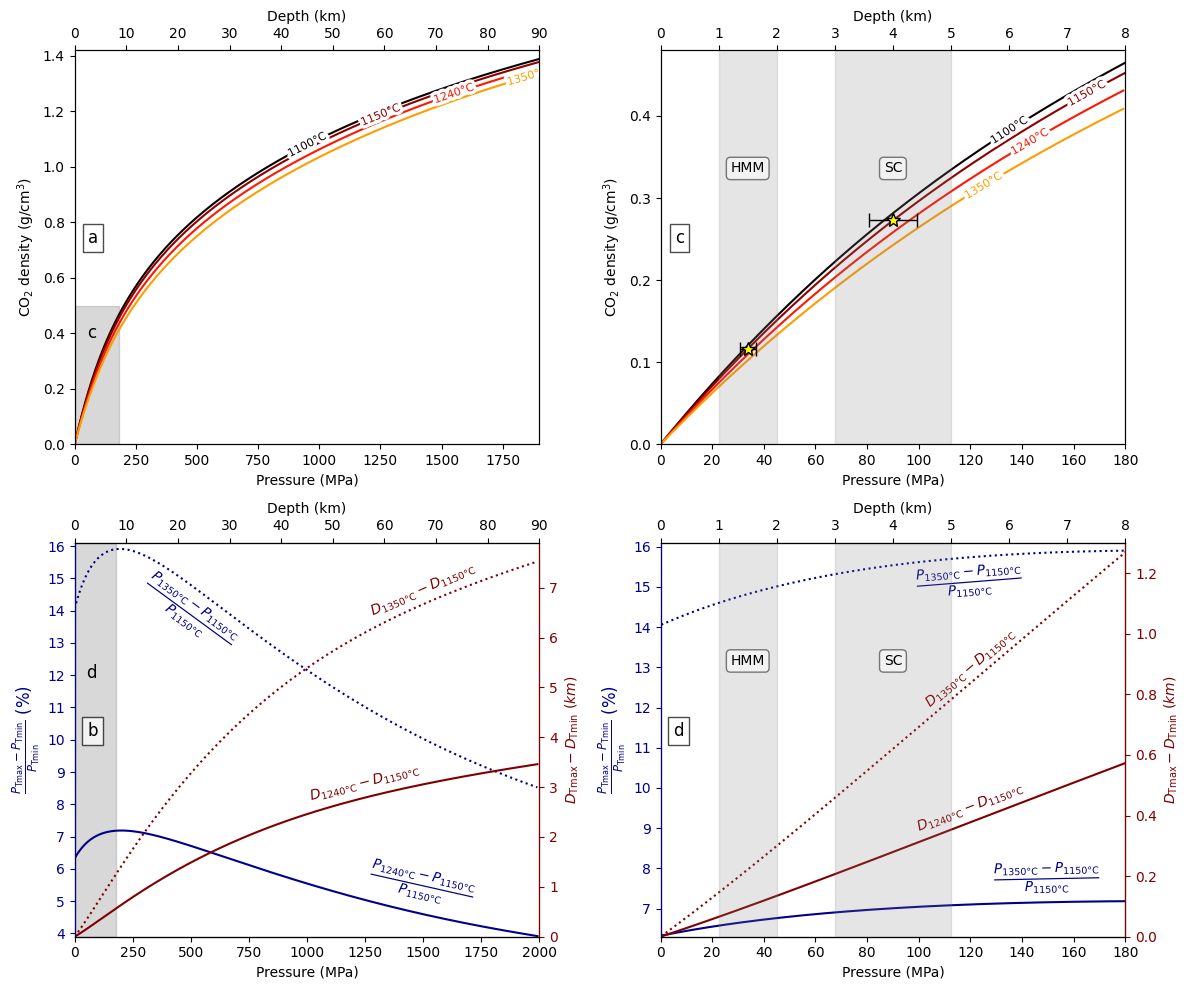

In [7]:
from matplotlib.ticker import MultipleLocator

# Color scale for temperature curves
colors = plt.cm.hot(np.linspace(0, 0.6, len(T_K)))

fig, ((ax1,ax3),(ax5,ax8)) = plt.subplots(2,2,figsize=(12,10))

#### Plot panel a ##########

min_P_ax1=0
max_P_ax1=2000
# Plotting CO2 density against Pressure on the left y-axis
for i in range(len(T_K)):
    ax1.plot(P_values_SW96[i]['Pressure (MPa)'][P_values_SW96[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], P_values_SW96[i]['CO2_dens_gcm3'][P_values_SW96[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], label=f'{T[i]}°C', color=colors[i])

# Secondary x-axis for depth in kilometers
ax2 = ax1.twiny()
for i in range(len(T_K)):
    ax2.plot(P_values_SW96[i]['Depth (km)'][P_values_SW96[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], P_values_SW96[i]['CO2_dens_gcm3'][P_values_SW96[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], color='none')

ax1.set_xlabel('Pressure (MPa)')
ax2.set_xlabel('Depth (km)')
ax1.set_ylabel('CO$_2$ density (g/cm$^3$)')


ax1.set_ylim(np.round([min(P_values_SW96[0]['CO2_dens_gcm3'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_SW96[0]['CO2_dens_gcm3'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])+0.02],2))

ax1.set_xlim(np.round([min(P_values_SW96[0]['Pressure (MPa)'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_SW96[0]['Pressure (MPa)'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-2))
ax2.set_xlim(np.round([min(P_values_SW96[0]['Depth (km)'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_SW96[0]['Depth (km)'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-1))


m=250
labelLines(ax1.get_lines(), zorder=3, xvals=[700+m,1000+m,1300+m,1600+m], fontsize=8)

# add panel indicator letter
bbox_props = dict(boxstyle='square', facecolor='white', edgecolor='k', alpha=0.7)
ax1.text(0.05, 0.50, 'a', transform=ax1.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)

# plot the insert box corresponding to panel c on panel a

min_P_ax2 = 0
max_P_ax2 = 180
maxrho=round(max(P_values_SW96[0]['CO2_dens_gcm3'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),1)

x_coordinates = [0, max_P_ax2]
y_coordinates = [0, maxrho]
text_box_coords = [x_coordinates[0] + 50, y_coordinates[1] -0.1]

ax1.fill_between(x_coordinates, 0, y_coordinates[1], color='gray', alpha=0.3)
ax1.text(*text_box_coords, 'c', fontsize=12, va='center', ha='left')

############## Now plot panel c #############

for i in range(len(T_K)):
    ax3.plot(P_values_SW96[i]['Pressure (MPa)'][P_values_SW96[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], P_values_SW96[i]['CO2_dens_gcm3'][P_values_SW96[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], label=f'{T[i]}°C', color=colors[i])

# secondary x-axis for depth in kilometers
ax4 = ax3.twiny()
for i in range(len(T_K)):
    ax4.plot(P_values_SW96[i]['Depth (km)'][P_values_SW96[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], P_values_SW96[i]['CO2_dens_gcm3'][P_values_SW96[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], color='none')

ax3.set_xlabel('Pressure (MPa)')
ax4.set_xlabel('Depth (km)')
ax3.set_ylabel('CO$_2$ density (g/cm$^3$)')

ax4.xaxis.set_major_locator(MultipleLocator(1))
ax3.xaxis.set_major_locator(MultipleLocator(20))

ylims_ax2=np.round([min(P_values_SW96[0]['CO2_dens_gcm3'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_SW96[0]['CO2_dens_gcm3'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])+0.02],2)

ax3.set_ylim(ylims_ax2)
ax3.set_xlim(np.round([min(P_values_SW96[0]['Pressure (MPa)'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_SW96[0]['Pressure (MPa)'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])],-1))
ax4.set_xlim(np.round([min(P_values_SW96[0]['Depth (km)'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_SW96[0]['Depth (km)'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])]))

ax4.fill_between([1, 2], ylims_ax2[0],ylims_ax2[1], color='gray', alpha=0.2, zorder=-1)
ax4.fill_between([3, 5], ylims_ax2[0],ylims_ax2[1], color='gray', alpha=0.2, zorder=-1)

labelLines(ax3.get_lines(), zorder=3, xvals=[max_P_ax2-45, max_P_ax2-15, max_P_ax2-37,max_P_ax2-55], fontsize=8)

# Add reservoir indicator boxes within the filled areas
ax4.text(1.5, ylims_ax2[1]-0.3*ylims_ax2[1], 'HMM', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)
ax4.text(4, ylims_ax2[1]-0.3*ylims_ax2[1], 'SC', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)

ax4.errorbar(MC_P_starFI_SW96['SingleFI_D_km'],MC_P_starFI_SW96['CO2_dens_gcm3'],xerr=MC_P_starFI_SW96['std_dev_MC_D_km'],fmt='*',zorder=3,markersize=10,ecolor='k',capsize=5,mfc='yellow',mec='k',elinewidth=1)

ax3.text(0.05, 0.5, 'c', transform=ax3.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)


############## plot panel b ########################

filter=[P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]

pressure1b=ax5.plot(P_values_SW96[1]['Pressure (MPa)'],100*((P_values_SW96[3]['Pressure (MPa)']/P_values_SW96[1]['Pressure (MPa)'])-1),color='darkblue',linestyle=':',label=r'$\frac{P_{\text{1350°C}} - P_{\text{1150°C}}}{P_{\text{1150°C}}}$') # For guess vs 1350
pressure2b=ax5.plot(P_values_SW96[1]['Pressure (MPa)'],100*((P_values_SW96[2]['Pressure (MPa)']/P_values_SW96[1]['Pressure (MPa)'])-1),color='darkblue',linestyle='-',label=r'$\frac{P_{\text{1240°C}} - P_{\text{1150°C}}}{P_{\text{1150°C}}}$') # FOr average measured FI vs guess

ax6=ax5.twinx()
ax6.plot(P_values_SW96[1]['Pressure (MPa)'],100*((P_values_SW96[3]['Pressure (MPa)']/P_values_SW96[1]['Pressure (MPa)'])-1),color='none')

depth1b=ax6.plot(P_values_SW96[1]['Pressure (MPa)'],P_values_SW96[3]['Depth (km)']-P_values_SW96[1]['Depth (km)'],color='maroon',linestyle=':',label=r'${D_{\text{1350°C}} - D_{\text{1150°C}}}$')
depth2b=ax6.plot(P_values_SW96[1]['Pressure (MPa)'],P_values_SW96[2]['Depth (km)']-P_values_SW96[1]['Depth (km)'],color='maroon',label=r'${D_{\text{1240°C}} - D_{\text{1150°C}}}$')

ax7=ax5.twiny()
ax7.plot(P_values_SW96[1]['Depth (km)'],100*((P_values_SW96[3]['Pressure (MPa)']/P_values_SW96[1]['Pressure (MPa)'])-1),color='none')

ax5.set_xlim(np.round([min(P_values_SW96[1]['Pressure (MPa)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_SW96[1]['Pressure (MPa)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-2))
ax7.set_xlim(np.round([min(P_values_SW96[1]['Depth (km)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_SW96[1]['Depth (km)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-1))

ax5.set_ylim(np.round([min(100*((P_values_SW96[2]['Pressure (MPa)']/P_values_SW96[1]['Pressure (MPa)'])-1)),
                       max(100*((P_values_SW96[3]['Pressure (MPa)']/P_values_SW96[1]['Pressure (MPa)'])-1))
                       +0.01*max(100*((P_values_SW96[3]['Pressure (MPa)']/P_values_SW96[1]['Pressure (MPa)'])-1))],1))
ax6.set_ylim(np.round([min(P_values_SW96[2]['Depth (km)']-P_values_SW96[1]['Depth (km)']),
                       max(P_values_SW96[3]['Depth (km)']-P_values_SW96[1]['Depth (km)'])
                       +0.05*max(P_values_SW96[3]['Depth (km)']-P_values_SW96[1]['Depth (km)'])],1))

ax5.yaxis.set_major_locator(MultipleLocator(1))

ax6.set_ylabel(r'${D_{\text{Tmax}} - D_{\text{Tmin}}} \ (km)$',color='maroon')
ax5.set_ylabel(r'$\frac{P_{\text{Tmax}} - P_{\text{Tmin}}}{P_{\text{Tmin}}} \ (\%)$',color='darkblue',fontsize=12)
ax5.set_xlabel('Pressure (MPa)')
ax7.set_xlabel('Depth (km)')

ax6.tick_params(axis='y', color='maroon',labelcolor='maroon')
ax7.spines['right'].set_color('maroon')

ax5.tick_params(axis='y', color='darkblue',labelcolor='darkblue')
ax7.spines['left'].set_color('darkblue')

ax7.text(0.05, 0.50, 'b', transform=ax7.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)


x_coordinates = [0, max_P_ax2]
y_coordinates = np.round([min(100*((P_values_SW96[2]['Pressure (MPa)']/P_values_SW96[1]['Pressure (MPa)'])-1)),
                   max(100*((P_values_SW96[3]['Pressure (MPa)']/P_values_SW96[1]['Pressure (MPa)'])-1))
                   +0.01*max(100*((P_values_SW96[3]['Pressure (MPa)']/P_values_SW96[1]['Pressure (MPa)'])-1))],1)
text_box_coords = [x_coordinates[0] + 50, y_coordinates[1] -0.25*y_coordinates[1]]

ax5.fill_between(x_coordinates, y_coordinates[0], y_coordinates[1], color='gray', alpha=0.3)
ax5.text(*text_box_coords, 'd', fontsize=12, va='center', ha='left')


############## plot panel d ########################

pressure1d=ax8.plot(P_values_SW96[1]['Pressure (MPa)'],100*((P_values_SW96[3]['Pressure (MPa)']/P_values_SW96[1]['Pressure (MPa)'])-1),color='darkblue',linestyle=':',label=r'$\frac{P_{\text{1350°C}} - P_{\text{1150°C}}}{P_{\text{1150°C}}}$') # For guess vs 1350
pressure2d=ax8.plot(P_values_SW96[1]['Pressure (MPa)'],100*((P_values_SW96[2]['Pressure (MPa)']/P_values_SW96[1]['Pressure (MPa)'])-1),color='darkblue',linestyle='-',label=r'$\frac{P_{\text{1350°C}} - P_{\text{1150°C}}}{P_{\text{1150°C}}}$') # FOr average measured FI vs guess

ax9=ax8.twinx()
ax9.plot(P_values_SW96[1]['Pressure (MPa)'],100*((P_values_SW96[3]['Pressure (MPa)']/P_values_SW96[1]['Pressure (MPa)'])-1),color='none')

depth1d=ax9.plot(P_values_SW96[1]['Pressure (MPa)'],P_values_SW96[3]['Depth (km)']-P_values_SW96[1]['Depth (km)'],color='maroon',linestyle=':',label=r'${D_{\text{1350°C}} - D_{\text{1150°C}}}$')
depth2d=ax9.plot(P_values_SW96[1]['Pressure (MPa)'],P_values_SW96[2]['Depth (km)']-P_values_SW96[1]['Depth (km)'],color='maroon',label=r'${D_{\text{1240°C}} - D_{\text{1150°C}}}$')

ax10=ax8.twiny()
ax10.plot(P_values_SW96[1]['Depth (km)'],100*((P_values_SW96[3]['Pressure (MPa)']/P_values_SW96[1]['Pressure (MPa)'])-1),color='none')

ax8.set_xlim(np.round([min(P_values_SW96[1]['Pressure (MPa)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_SW96[1]['Pressure (MPa)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])],-1))
ax10.set_xlim(np.round([min(P_values_SW96[1]['Depth (km)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_SW96[1]['Depth (km)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])]))

ax8.set_ylim(np.round([min(100*((P_values_SW96[2]['Pressure (MPa)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/P_values_SW96[1]['Pressure (MPa)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1)),
                       max(100*((P_values_SW96[3]['Pressure (MPa)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/P_values_SW96[1]['Pressure (MPa)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1))
                       +0.01*max(100*((P_values_SW96[3]['Pressure (MPa)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/P_values_SW96[1]['Pressure (MPa)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1))],1))
ax9.set_ylim(np.round([min(P_values_SW96[2]['Depth (km)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]-P_values_SW96[1]['Depth (km)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),
                       max(P_values_SW96[3]['Depth (km)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]-P_values_SW96[1]['Depth (km)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])
                       +0.05*max(P_values_SW96[3]['Depth (km)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]-P_values_SW96[1]['Depth (km)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])],1))

ylims_ax8=np.round([min(100*((P_values_SW96[2]['Pressure (MPa)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/P_values_SW96[1]['Pressure (MPa)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1)),
                       max(100*((P_values_SW96[3]['Pressure (MPa)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/P_values_SW96[1]['Pressure (MPa)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1))
                       +0.01*max(100*((P_values_SW96[3]['Pressure (MPa)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/P_values_SW96[1]['Pressure (MPa)'][P_values_SW96[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1))],1)

# Add reservoir indicator boxes and names within the filled areas

ax10.fill_between([1, 2], ylims_ax8[0],ylims_ax8[1], color='gray', alpha=0.2, zorder=-1)
ax10.fill_between([3, 5], ylims_ax8[0],ylims_ax8[1], color='gray', alpha=0.2, zorder=-1)
ax10.text(1.5, ylims_ax8[1]-0.3* (ylims_ax8[1]-ylims_ax8[0]), 'HMM', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)
ax10.text(4, ylims_ax8[1]-0.3* (ylims_ax8[1]-ylims_ax8[0]), 'SC', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)

#

ax8.yaxis.set_major_locator(MultipleLocator(1))

ax9.set_ylabel(r'${D_{\text{Tmax}} - D_{\text{Tmin}}} \ (km)$',color='maroon')
ax8.set_ylabel(r'$\frac{P_{\text{Tmax}} - P_{\text{Tmin}}}{P_{\text{Tmin}}} \ (\%)$',color='darkblue',fontsize=12)
ax8.set_xlabel('Pressure (MPa)')
ax10.set_xlabel('Depth (km)')

ax9.tick_params(axis='y', color='maroon',labelcolor='maroon')
ax10.spines['right'].set_color('maroon')

ax8.tick_params(axis='y', color='darkblue',labelcolor='darkblue')
ax10.spines['left'].set_color('darkblue')

ax10.text(0.05, 0.50, 'd', transform=ax10.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)

# ax8.text(25, ylims_ax8[1]-0.05* (ylims_ax8[1]-ylims_ax8[0]), 'T = 1150 °C', ha='center', va='center',zorder=2,color = 'k')


labelLines(pressure1b, zorder=3, xvals=500, yoffsets=-0.9, fontsize=14)
labelLines(pressure2b, zorder=3, xvals=1500, yoffsets=+0.9, fontsize=14)
labelLines(depth1b, zorder=3, xvals=1500, yoffsets=0.3,fontsize=10)
labelLines(depth2b, zorder=3, xvals=1250, yoffsets=0.3,fontsize=10)

labelLines(pressure1d, zorder=3, xvals=120, yoffsets=-0.6, fontsize=14)
labelLines(pressure2d, zorder=3, xvals=150, yoffsets=+0.6, fontsize=14)
labelLines(depth1d, zorder=3, xvals=120, yoffsets=0.05,fontsize=10)
labelLines(depth2d, zorder=3, xvals=120, yoffsets=0.05,fontsize=10)

fig.tight_layout()

plt.show()

plt.rcParams["pdf.fonttype"]=42

fig.savefig("FigS_SWTsens.pdf")

## Sterner and Pitzer pure CO2 Temperature sensitivity

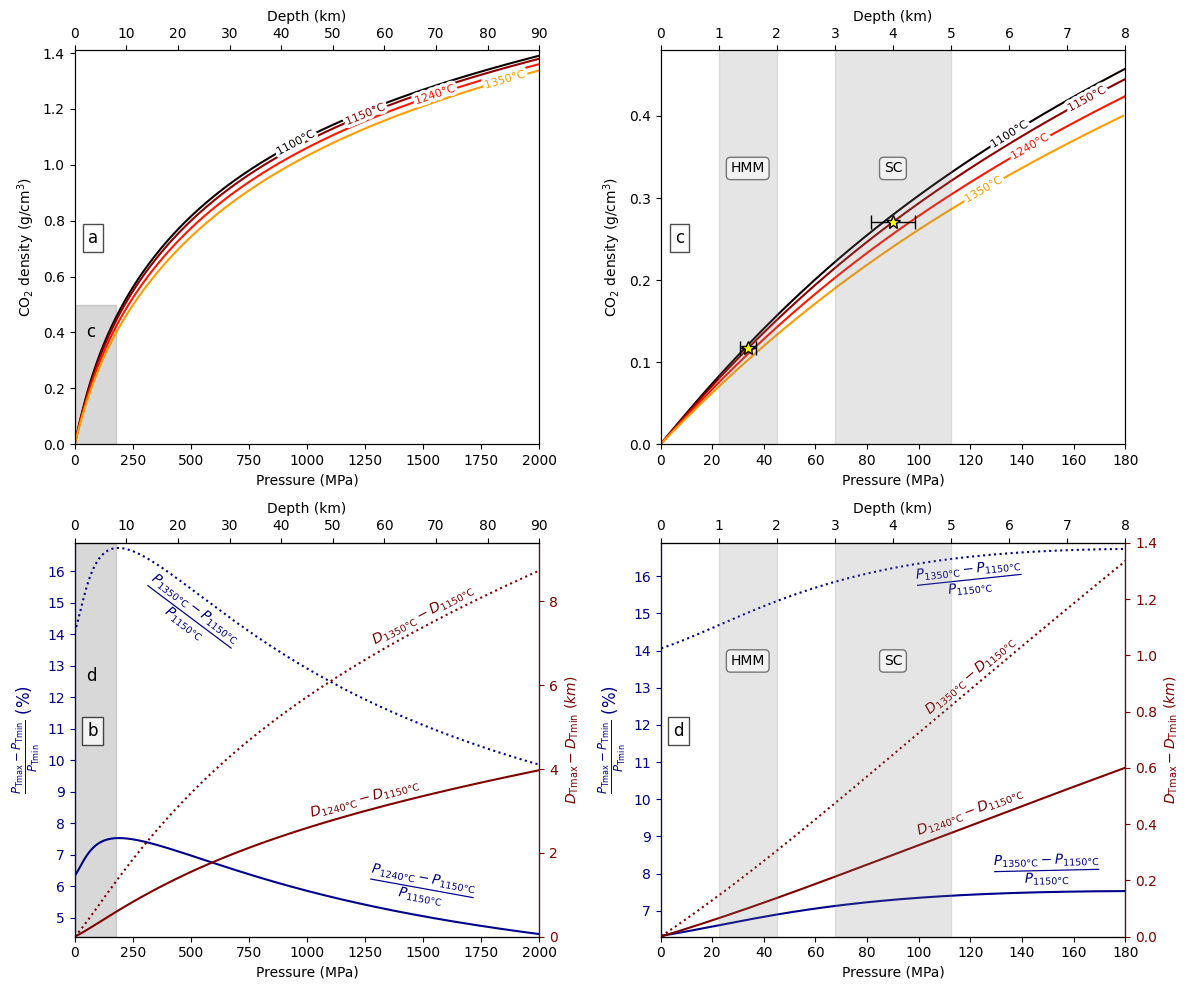

In [8]:
from matplotlib.ticker import MultipleLocator

# Color scale for temperature curves
colors = plt.cm.hot(np.linspace(0, 0.6, len(T_K)))

fig, ((ax1,ax3),(ax5,ax8)) = plt.subplots(2,2,figsize=(12,10))

#### Plot panel a ##########

min_P_ax1=0
max_P_ax1=2000
# Plotting CO2 density against Pressure on the left y-axis
for i in range(len(T_K)):
    ax1.plot(P_values_SP94[i]['Pressure (MPa)'][P_values_SP94[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], P_values_SP94[i]['CO2_dens_gcm3'][P_values_SP94[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], label=f'{T[i]}°C', color=colors[i])

# Secondary x-axis for depth in kilometers
ax2 = ax1.twiny()
for i in range(len(T_K)):
    ax2.plot(P_values_SP94[i]['Depth (km)'][P_values_SP94[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], P_values_SP94[i]['CO2_dens_gcm3'][P_values_SP94[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], color='none')

ax1.set_xlabel('Pressure (MPa)')
ax2.set_xlabel('Depth (km)')
ax1.set_ylabel('CO$_2$ density (g/cm$^3$)')


ax1.set_ylim(np.round([min(P_values_SP94[0]['CO2_dens_gcm3'][P_values_SP94[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_SP94[0]['CO2_dens_gcm3'][P_values_SP94[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])+0.02],2))

ax1.set_xlim(np.round([min(P_values_SP94[0]['Pressure (MPa)'][P_values_SP94[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_SP94[0]['Pressure (MPa)'][P_values_SP94[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-2))
ax2.set_xlim(np.round([min(P_values_SP94[0]['Depth (km)'][P_values_SP94[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_SP94[0]['Depth (km)'][P_values_SP94[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-1))


m=250
labelLines(ax1.get_lines(), zorder=3, xvals=[700+m,1000+m,1300+m,1600+m], fontsize=8)

# add panel indicator letter
bbox_props = dict(boxstyle='square', facecolor='white', edgecolor='k', alpha=0.7)
ax1.text(0.05, 0.50, 'a', transform=ax1.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)

# plot the insert box corresponding to panel c on panel a

min_P_ax2 = 0
max_P_ax2 = 180
maxrho=round(max(P_values_SP94[0]['CO2_dens_gcm3'][P_values_SP94[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),1)

x_coordinates = [0, max_P_ax2]
y_coordinates = [0, maxrho]
text_box_coords = [x_coordinates[0] + 50, y_coordinates[1] -0.1]

ax1.fill_between(x_coordinates, 0, y_coordinates[1], color='gray', alpha=0.3)
ax1.text(*text_box_coords, 'c', fontsize=12, va='center', ha='left')

############## Now plot panel c #############

for i in range(len(T_K)):
    ax3.plot(P_values_SP94[i]['Pressure (MPa)'][P_values_SP94[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], P_values_SP94[i]['CO2_dens_gcm3'][P_values_SP94[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], label=f'{T[i]}°C', color=colors[i])

# secondary x-axis for depth in kilometers
ax4 = ax3.twiny()
for i in range(len(T_K)):
    ax4.plot(P_values_SP94[i]['Depth (km)'][P_values_SP94[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], P_values_SP94[i]['CO2_dens_gcm3'][P_values_SP94[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], color='none')

ax3.set_xlabel('Pressure (MPa)')
ax4.set_xlabel('Depth (km)')
ax3.set_ylabel('CO$_2$ density (g/cm$^3$)')

ax4.xaxis.set_major_locator(MultipleLocator(1))
ax3.xaxis.set_major_locator(MultipleLocator(20))

ylims_ax2=np.round([min(P_values_SP94[0]['CO2_dens_gcm3'][P_values_SP94[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_SP94[0]['CO2_dens_gcm3'][P_values_SP94[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])+0.02],2)

ax3.set_ylim(ylims_ax2)
ax3.set_xlim(np.round([min(P_values_SP94[0]['Pressure (MPa)'][P_values_SP94[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_SP94[0]['Pressure (MPa)'][P_values_SP94[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])],-1))
ax4.set_xlim(np.round([min(P_values_SP94[0]['Depth (km)'][P_values_SP94[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_SP94[0]['Depth (km)'][P_values_SP94[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])]))

ax4.fill_between([1, 2], ylims_ax2[0],ylims_ax2[1], color='gray', alpha=0.2, zorder=-1)
ax4.fill_between([3, 5], ylims_ax2[0],ylims_ax2[1], color='gray', alpha=0.2, zorder=-1)

labelLines(ax3.get_lines(), zorder=3, xvals=[max_P_ax2-45, max_P_ax2-15, max_P_ax2-37,max_P_ax2-55], fontsize=8)

# Add reservoir indicator boxes within the filled areas
ax4.text(1.5, ylims_ax2[1]-0.3*ylims_ax2[1], 'HMM', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)
ax4.text(4, ylims_ax2[1]-0.3*ylims_ax2[1], 'SC', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)

ax4.errorbar(MC_P_starFI_SP94['SingleFI_D_km'],MC_P_starFI_SP94['CO2_dens_gcm3'],xerr=MC_P_starFI_SP94['std_dev_MC_D_km'],fmt='*',zorder=3,markersize=10,ecolor='k',capsize=5,mfc='yellow',mec='k',elinewidth=1)

ax3.text(0.05, 0.5, 'c', transform=ax3.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)


############## plot panel b ########################

filter=[P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]

pressure1b=ax5.plot(P_values_SP94[1]['Pressure (MPa)'],100*((P_values_SP94[3]['Pressure (MPa)']/P_values_SP94[1]['Pressure (MPa)'])-1),color='darkblue',linestyle=':',label=r'$\frac{P_{\text{1350°C}} - P_{\text{1150°C}}}{P_{\text{1150°C}}}$') # For guess vs 1350
pressure2b=ax5.plot(P_values_SP94[1]['Pressure (MPa)'],100*((P_values_SP94[2]['Pressure (MPa)']/P_values_SP94[1]['Pressure (MPa)'])-1),color='darkblue',linestyle='-',label=r'$\frac{P_{\text{1240°C}} - P_{\text{1150°C}}}{P_{\text{1150°C}}}$') # FOr average measured FI vs guess

ax6=ax5.twinx()
ax6.plot(P_values_SP94[1]['Pressure (MPa)'],100*((P_values_SP94[3]['Pressure (MPa)']/P_values_SP94[1]['Pressure (MPa)'])-1),color='none')

depth1b=ax6.plot(P_values_SP94[1]['Pressure (MPa)'],P_values_SP94[3]['Depth (km)']-P_values_SP94[1]['Depth (km)'],color='maroon',linestyle=':',label=r'${D_{\text{1350°C}} - D_{\text{1150°C}}}$')
depth2b=ax6.plot(P_values_SP94[1]['Pressure (MPa)'],P_values_SP94[2]['Depth (km)']-P_values_SP94[1]['Depth (km)'],color='maroon',label=r'${D_{\text{1240°C}} - D_{\text{1150°C}}}$')

ax7=ax5.twiny()
ax7.plot(P_values_SP94[1]['Depth (km)'],100*((P_values_SP94[3]['Pressure (MPa)']/P_values_SP94[1]['Pressure (MPa)'])-1),color='none')

ax5.set_xlim(np.round([min(P_values_SP94[1]['Pressure (MPa)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_SP94[1]['Pressure (MPa)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-2))
ax7.set_xlim(np.round([min(P_values_SP94[1]['Depth (km)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_SP94[1]['Depth (km)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-1))

ax5.set_ylim(np.round([min(100*((P_values_SP94[2]['Pressure (MPa)']/P_values_SP94[1]['Pressure (MPa)'])-1)),
                       max(100*((P_values_SP94[3]['Pressure (MPa)']/P_values_SP94[1]['Pressure (MPa)'])-1))
                       +0.01*max(100*((P_values_SP94[3]['Pressure (MPa)']/P_values_SP94[1]['Pressure (MPa)'])-1))],1))
ax6.set_ylim(np.round([min(P_values_SP94[2]['Depth (km)']-P_values_SP94[1]['Depth (km)']),
                       max(P_values_SP94[3]['Depth (km)']-P_values_SP94[1]['Depth (km)'])
                       +0.05*max(P_values_SP94[3]['Depth (km)']-P_values_SP94[1]['Depth (km)'])],1))

ax5.yaxis.set_major_locator(MultipleLocator(1))

ax6.set_ylabel(r'${D_{\text{Tmax}} - D_{\text{Tmin}}} \ (km)$',color='maroon')
ax5.set_ylabel(r'$\frac{P_{\text{Tmax}} - P_{\text{Tmin}}}{P_{\text{Tmin}}} \ (\%)$',color='darkblue',fontsize=12)
ax5.set_xlabel('Pressure (MPa)')
ax7.set_xlabel('Depth (km)')

ax6.tick_params(axis='y', color='maroon',labelcolor='maroon')
ax7.spines['right'].set_color('maroon')

ax5.tick_params(axis='y', color='darkblue',labelcolor='darkblue')
ax7.spines['left'].set_color('darkblue')

ax7.text(0.05, 0.50, 'b', transform=ax7.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)


x_coordinates = [0, max_P_ax2]
y_coordinates = np.round([min(100*((P_values_SP94[2]['Pressure (MPa)']/P_values_SP94[1]['Pressure (MPa)'])-1)),
                   max(100*((P_values_SP94[3]['Pressure (MPa)']/P_values_SP94[1]['Pressure (MPa)'])-1))
                   +0.01*max(100*((P_values_SP94[3]['Pressure (MPa)']/P_values_SP94[1]['Pressure (MPa)'])-1))],1)
text_box_coords = [x_coordinates[0] + 50, y_coordinates[1] -0.25*y_coordinates[1]]

ax5.fill_between(x_coordinates, y_coordinates[0], y_coordinates[1], color='gray', alpha=0.3)
ax5.text(*text_box_coords, 'd', fontsize=12, va='center', ha='left')


############## plot panel d ########################

pressure1d=ax8.plot(P_values_SP94[1]['Pressure (MPa)'],100*((P_values_SP94[3]['Pressure (MPa)']/P_values_SP94[1]['Pressure (MPa)'])-1),color='darkblue',linestyle=':',label=r'$\frac{P_{\text{1350°C}} - P_{\text{1150°C}}}{P_{\text{1150°C}}}$') # For guess vs 1350
pressure2d=ax8.plot(P_values_SP94[1]['Pressure (MPa)'],100*((P_values_SP94[2]['Pressure (MPa)']/P_values_SP94[1]['Pressure (MPa)'])-1),color='darkblue',linestyle='-',label=r'$\frac{P_{\text{1350°C}} - P_{\text{1150°C}}}{P_{\text{1150°C}}}$') # FOr average measured FI vs guess

ax9=ax8.twinx()
ax9.plot(P_values_SP94[1]['Pressure (MPa)'],100*((P_values_SP94[3]['Pressure (MPa)']/P_values_SP94[1]['Pressure (MPa)'])-1),color='none')

depth1d=ax9.plot(P_values_SP94[1]['Pressure (MPa)'],P_values_SP94[3]['Depth (km)']-P_values_SP94[1]['Depth (km)'],color='maroon',linestyle=':',label=r'${D_{\text{1350°C}} - D_{\text{1150°C}}}$')
depth2d=ax9.plot(P_values_SP94[1]['Pressure (MPa)'],P_values_SP94[2]['Depth (km)']-P_values_SP94[1]['Depth (km)'],color='maroon',label=r'${D_{\text{1240°C}} - D_{\text{1150°C}}}$')

ax10=ax8.twiny()
ax10.plot(P_values_SP94[1]['Depth (km)'],100*((P_values_SP94[3]['Pressure (MPa)']/P_values_SP94[1]['Pressure (MPa)'])-1),color='none')

ax8.set_xlim(np.round([min(P_values_SP94[1]['Pressure (MPa)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_SP94[1]['Pressure (MPa)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])],-1))
ax10.set_xlim(np.round([min(P_values_SP94[1]['Depth (km)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_SP94[1]['Depth (km)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])]))

ax8.set_ylim(np.round([min(100*((P_values_SP94[2]['Pressure (MPa)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/P_values_SP94[1]['Pressure (MPa)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1)),
                       max(100*((P_values_SP94[3]['Pressure (MPa)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/P_values_SP94[1]['Pressure (MPa)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1))
                       +0.01*max(100*((P_values_SP94[3]['Pressure (MPa)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/P_values_SP94[1]['Pressure (MPa)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1))],1))
ax9.set_ylim(np.round([min(P_values_SP94[2]['Depth (km)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]-P_values_SP94[1]['Depth (km)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),
                       max(P_values_SP94[3]['Depth (km)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]-P_values_SP94[1]['Depth (km)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])
                       +0.05*max(P_values_SP94[3]['Depth (km)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]-P_values_SP94[1]['Depth (km)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])],1))

ylims_ax8=np.round([min(100*((P_values_SP94[2]['Pressure (MPa)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/P_values_SP94[1]['Pressure (MPa)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1)),
                       max(100*((P_values_SP94[3]['Pressure (MPa)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/P_values_SP94[1]['Pressure (MPa)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1))
                       +0.01*max(100*((P_values_SP94[3]['Pressure (MPa)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/P_values_SP94[1]['Pressure (MPa)'][P_values_SP94[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1))],1)

# Add reservoir indicator boxes and names within the filled areas

ax10.fill_between([1, 2], ylims_ax8[0],ylims_ax8[1], color='gray', alpha=0.2, zorder=-1)
ax10.fill_between([3, 5], ylims_ax8[0],ylims_ax8[1], color='gray', alpha=0.2, zorder=-1)
ax10.text(1.5, ylims_ax8[1]-0.3* (ylims_ax8[1]-ylims_ax8[0]), 'HMM', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)
ax10.text(4, ylims_ax8[1]-0.3* (ylims_ax8[1]-ylims_ax8[0]), 'SC', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)

#

ax8.yaxis.set_major_locator(MultipleLocator(1))

ax9.set_ylabel(r'${D_{\text{Tmax}} - D_{\text{Tmin}}} \ (km)$',color='maroon')
ax8.set_ylabel(r'$\frac{P_{\text{Tmax}} - P_{\text{Tmin}}}{P_{\text{Tmin}}} \ (\%)$',color='darkblue',fontsize=12)
ax8.set_xlabel('Pressure (MPa)')
ax10.set_xlabel('Depth (km)')

ax9.tick_params(axis='y', color='maroon',labelcolor='maroon')
ax10.spines['right'].set_color('maroon')

ax8.tick_params(axis='y', color='darkblue',labelcolor='darkblue')
ax10.spines['left'].set_color('darkblue')

ax10.text(0.05, 0.50, 'd', transform=ax10.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)

# ax8.text(25, ylims_ax8[1]-0.05* (ylims_ax8[1]-ylims_ax8[0]), 'T = 1150 °C', ha='center', va='center',zorder=2,color = 'k')

labelLines(pressure1b, zorder=3, xvals=500, yoffsets=-0.9, fontsize=14)
labelLines(pressure2b, zorder=3, xvals=1500, yoffsets=+0.9, fontsize=14)
labelLines(depth1b, zorder=3, xvals=1500, yoffsets=0.3,fontsize=10)
labelLines(depth2b, zorder=3, xvals=1250, yoffsets=0.3,fontsize=10)

labelLines(pressure1d, zorder=3, xvals=120, yoffsets=-0.6, fontsize=14)
labelLines(pressure2d, zorder=3, xvals=150, yoffsets=+0.6, fontsize=14)
labelLines(depth1d, zorder=3, xvals=120, yoffsets=0.05,fontsize=10)
labelLines(depth2d, zorder=3, xvals=120, yoffsets=0.05,fontsize=10)

fig.tight_layout()

plt.show()

plt.rcParams["pdf.fonttype"]=42

fig.savefig("FigS_SPTsens.pdf")

## Duan and Zhang (2006) EOS temperature sensitivity for XH2O=0.1

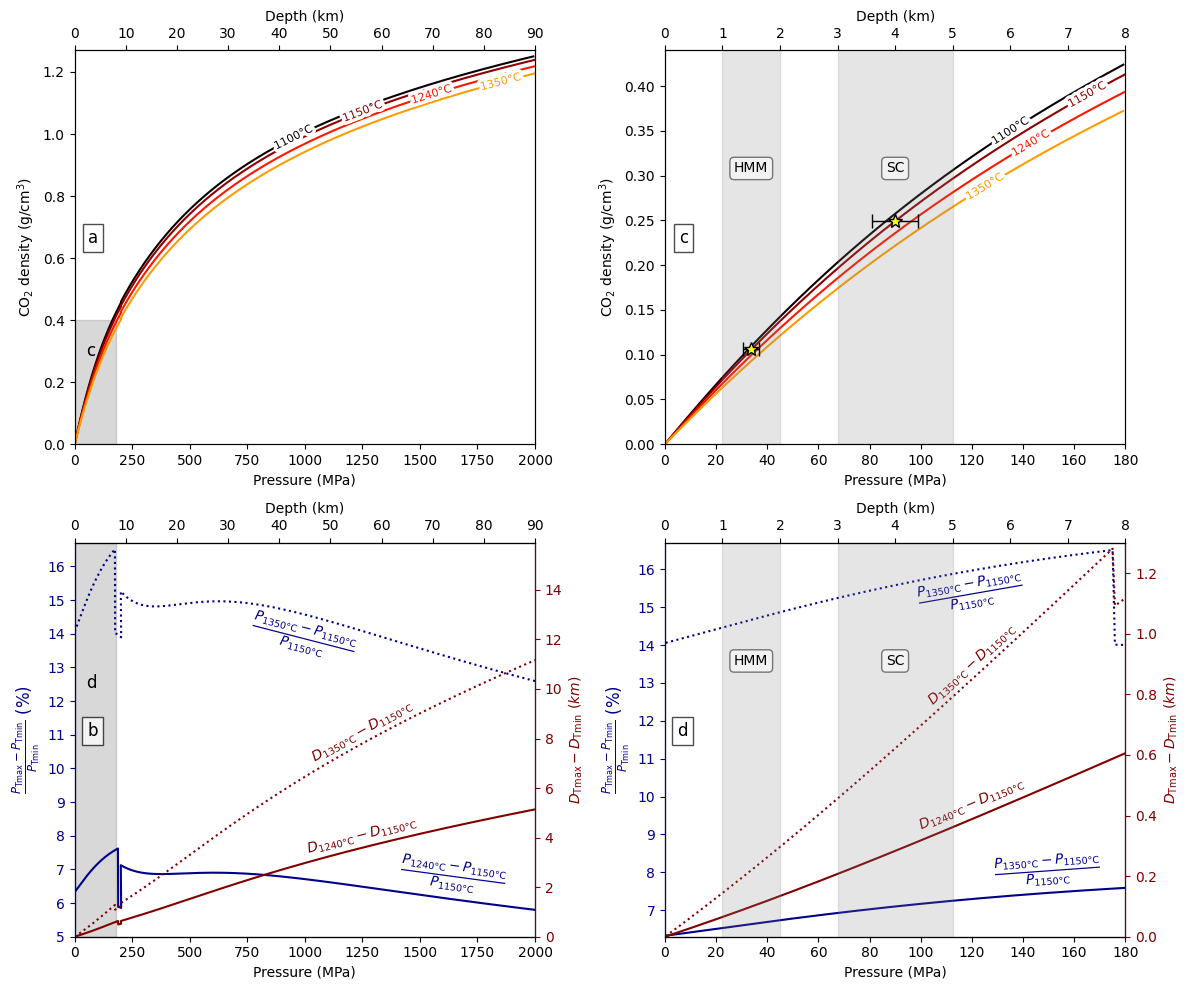

In [9]:
from matplotlib.ticker import MultipleLocator

# Color scale for temperature curves
colors = plt.cm.hot(np.linspace(0, 0.6, len(T_K)))

fig, ((ax1,ax3),(ax5,ax8)) = plt.subplots(2,2,figsize=(12,10))

#### Plot panel a ##########

min_P_ax1=0
max_P_ax1=2000
# Plotting CO2 density against Pressure on the left y-axis
for i in range(len(T_K)):
    ax1.plot(P_values_DZ06[i]['Pressure (MPa)'][P_values_DZ06[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], P_values_DZ06[i]['CO2_dens_gcm3'][P_values_DZ06[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], label=f'{T[i]}°C', color=colors[i])

# Secondary x-axis for depth in kilometers
ax2 = ax1.twiny()
for i in range(len(T_K)):
    ax2.plot(P_values_DZ06[i]['Depth (km)'][P_values_DZ06[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], P_values_DZ06[i]['CO2_dens_gcm3'][P_values_DZ06[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], color='none')

ax1.set_xlabel('Pressure (MPa)')
ax2.set_xlabel('Depth (km)')
ax1.set_ylabel('CO$_2$ density (g/cm$^3$)')


ax1.set_ylim(np.round([min(P_values_DZ06[0]['CO2_dens_gcm3'][P_values_DZ06[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_DZ06[0]['CO2_dens_gcm3'][P_values_DZ06[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])+0.02],2))

ax1.set_xlim(np.round([min(P_values_DZ06[0]['Pressure (MPa)'][P_values_DZ06[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_DZ06[0]['Pressure (MPa)'][P_values_DZ06[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-2))
ax2.set_xlim(np.round([min(P_values_DZ06[0]['Depth (km)'][P_values_DZ06[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_DZ06[0]['Depth (km)'][P_values_DZ06[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-1))


m=250
labelLines(ax1.get_lines(), zorder=3, xvals=[700+m,1000+m,1300+m,1600+m], fontsize=8)

# add panel indicator letter
bbox_props = dict(boxstyle='square', facecolor='white', edgecolor='k', alpha=0.7)
ax1.text(0.05, 0.50, 'a', transform=ax1.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)

# plot the insert box corresponding to panel c on panel a

min_P_ax2 = 0
max_P_ax2 = 180
maxrho=round(max(P_values_DZ06[0]['CO2_dens_gcm3'][P_values_DZ06[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),1)

x_coordinates = [0, max_P_ax2]
y_coordinates = [0, maxrho]
text_box_coords = [x_coordinates[0] + 50, y_coordinates[1] -0.1]

ax1.fill_between(x_coordinates, 0, y_coordinates[1], color='gray', alpha=0.3)
ax1.text(*text_box_coords, 'c', fontsize=12, va='center', ha='left')

############## Now plot panel c #############

for i in range(len(T_K)):
    ax3.plot(P_values_DZ06[i]['Pressure (MPa)'][P_values_DZ06[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], P_values_DZ06[i]['CO2_dens_gcm3'][P_values_DZ06[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], label=f'{T[i]}°C', color=colors[i])

# secondary x-axis for depth in kilometers
ax4 = ax3.twiny()
for i in range(len(T_K)):
    ax4.plot(P_values_DZ06[i]['Depth (km)'][P_values_DZ06[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], P_values_DZ06[i]['CO2_dens_gcm3'][P_values_DZ06[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], color='none')

ax3.set_xlabel('Pressure (MPa)')
ax4.set_xlabel('Depth (km)')
ax3.set_ylabel('CO$_2$ density (g/cm$^3$)')

ax4.xaxis.set_major_locator(MultipleLocator(1))
ax3.xaxis.set_major_locator(MultipleLocator(20))

ylims_ax2=np.round([min(P_values_DZ06[0]['CO2_dens_gcm3'][P_values_DZ06[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_DZ06[0]['CO2_dens_gcm3'][P_values_DZ06[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])+0.02],2)

ax3.set_ylim(ylims_ax2)
ax3.set_xlim(np.round([min(P_values_DZ06[0]['Pressure (MPa)'][P_values_DZ06[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_DZ06[0]['Pressure (MPa)'][P_values_DZ06[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])],-1))
ax4.set_xlim(np.round([min(P_values_DZ06[0]['Depth (km)'][P_values_DZ06[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_DZ06[0]['Depth (km)'][P_values_DZ06[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])]))

ax4.fill_between([1, 2], ylims_ax2[0],ylims_ax2[1], color='gray', alpha=0.2, zorder=-1)
ax4.fill_between([3, 5], ylims_ax2[0],ylims_ax2[1], color='gray', alpha=0.2, zorder=-1)

labelLines(ax3.get_lines(), zorder=3, xvals=[max_P_ax2-45, max_P_ax2-15, max_P_ax2-37,max_P_ax2-55], fontsize=8)

# Add reservoir indicator boxes within the filled areas
ax4.text(1.5, ylims_ax2[1]-0.3*ylims_ax2[1], 'HMM', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)
ax4.text(4, ylims_ax2[1]-0.3*ylims_ax2[1], 'SC', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)

ax4.errorbar(MC_P_starFI_DZ06['SingleFI_D_km'],MC_P_starFI_DZ06['CO2_dens_gcm3'],xerr=MC_P_starFI_DZ06['std_dev_MC_D_km'],fmt='*',zorder=3,markersize=10,ecolor='k',capsize=5,mfc='yellow',mec='k',elinewidth=1)

ax3.text(0.05, 0.5, 'c', transform=ax3.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)


############## plot panel b ########################

filter=[P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]

pressure1b=ax5.plot(P_values_DZ06[1]['Pressure (MPa)'],100*((P_values_DZ06[3]['Pressure (MPa)']/P_values_DZ06[1]['Pressure (MPa)'])-1),color='darkblue',linestyle=':',label=r'$\frac{P_{\text{1350°C}} - P_{\text{1150°C}}}{P_{\text{1150°C}}}$') # For guess vs 1350
pressure2b=ax5.plot(P_values_DZ06[1]['Pressure (MPa)'],100*((P_values_DZ06[2]['Pressure (MPa)']/P_values_DZ06[1]['Pressure (MPa)'])-1),color='darkblue',linestyle='-',label=r'$\frac{P_{\text{1240°C}} - P_{\text{1150°C}}}{P_{\text{1150°C}}}$') # FOr average measured FI vs guess

ax6=ax5.twinx()
ax6.plot(P_values_DZ06[1]['Pressure (MPa)'],100*((P_values_DZ06[3]['Pressure (MPa)']/P_values_DZ06[1]['Pressure (MPa)'])-1),color='none')

depth1b=ax6.plot(P_values_DZ06[1]['Pressure (MPa)'],P_values_DZ06[3]['Depth (km)']-P_values_DZ06[1]['Depth (km)'],color='maroon',linestyle=':',label=r'${D_{\text{1350°C}} - D_{\text{1150°C}}}$')
depth2b=ax6.plot(P_values_DZ06[1]['Pressure (MPa)'],P_values_DZ06[2]['Depth (km)']-P_values_DZ06[1]['Depth (km)'],color='maroon',label=r'${D_{\text{1240°C}} - D_{\text{1150°C}}}$')

ax7=ax5.twiny()
ax7.plot(P_values_DZ06[1]['Depth (km)'],100*((P_values_DZ06[3]['Pressure (MPa)']/P_values_DZ06[1]['Pressure (MPa)'])-1),color='none')

ax5.set_xlim(np.round([min(P_values_DZ06[1]['Pressure (MPa)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_DZ06[1]['Pressure (MPa)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-2))
ax7.set_xlim(np.round([min(P_values_DZ06[1]['Depth (km)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_DZ06[1]['Depth (km)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-1))

ax5.set_ylim(np.round([min(100*((P_values_DZ06[2]['Pressure (MPa)']/P_values_DZ06[1]['Pressure (MPa)'])-1)),
                       max(100*((P_values_DZ06[3]['Pressure (MPa)']/P_values_DZ06[1]['Pressure (MPa)'])-1))
                       +0.01*max(100*((P_values_DZ06[3]['Pressure (MPa)']/P_values_DZ06[1]['Pressure (MPa)'])-1))],1))
ax6.set_ylim(np.round([min(P_values_DZ06[2]['Depth (km)']-P_values_DZ06[1]['Depth (km)']),
                       max(P_values_DZ06[3]['Depth (km)']-P_values_DZ06[1]['Depth (km)'])
                       +0.05*max(P_values_DZ06[3]['Depth (km)']-P_values_DZ06[1]['Depth (km)'])],1))

ax5.yaxis.set_major_locator(MultipleLocator(1))

ax6.set_ylabel(r'${D_{\text{Tmax}} - D_{\text{Tmin}}} \ (km)$',color='maroon')
ax5.set_ylabel(r'$\frac{P_{\text{Tmax}} - P_{\text{Tmin}}}{P_{\text{Tmin}}} \ (\%)$',color='darkblue',fontsize=12)
ax5.set_xlabel('Pressure (MPa)')
ax7.set_xlabel('Depth (km)')

ax6.tick_params(axis='y', color='maroon',labelcolor='maroon')
ax7.spines['right'].set_color('maroon')

ax5.tick_params(axis='y', color='darkblue',labelcolor='darkblue')
ax7.spines['left'].set_color('darkblue')

ax7.text(0.05, 0.50, 'b', transform=ax7.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)


x_coordinates = [0, max_P_ax2]
y_coordinates = np.round([min(100*((P_values_DZ06[2]['Pressure (MPa)']/P_values_DZ06[1]['Pressure (MPa)'])-1)),
                   max(100*((P_values_DZ06[3]['Pressure (MPa)']/P_values_DZ06[1]['Pressure (MPa)'])-1))
                   +0.01*max(100*((P_values_DZ06[3]['Pressure (MPa)']/P_values_DZ06[1]['Pressure (MPa)'])-1))],1)
text_box_coords = [x_coordinates[0] + 50, y_coordinates[1] -0.25*y_coordinates[1]]

ax5.fill_between(x_coordinates, y_coordinates[0], y_coordinates[1], color='gray', alpha=0.3)
ax5.text(*text_box_coords, 'd', fontsize=12, va='center', ha='left')


############## plot panel d ########################

pressure1d=ax8.plot(P_values_DZ06[1]['Pressure (MPa)'],100*((P_values_DZ06[3]['Pressure (MPa)']/P_values_DZ06[1]['Pressure (MPa)'])-1),color='darkblue',linestyle=':',label=r'$\frac{P_{\text{1350°C}} - P_{\text{1150°C}}}{P_{\text{1150°C}}}$') # For guess vs 1350
pressure2d=ax8.plot(P_values_DZ06[1]['Pressure (MPa)'],100*((P_values_DZ06[2]['Pressure (MPa)']/P_values_DZ06[1]['Pressure (MPa)'])-1),color='darkblue',linestyle='-',label=r'$\frac{P_{\text{1350°C}} - P_{\text{1150°C}}}{P_{\text{1150°C}}}$') # FOr average measured FI vs guess

ax9=ax8.twinx()
ax9.plot(P_values_DZ06[1]['Pressure (MPa)'],100*((P_values_DZ06[3]['Pressure (MPa)']/P_values_DZ06[1]['Pressure (MPa)'])-1),color='none')

depth1d=ax9.plot(P_values_DZ06[1]['Pressure (MPa)'],P_values_DZ06[3]['Depth (km)']-P_values_DZ06[1]['Depth (km)'],color='maroon',linestyle=':',label=r'${D_{\text{1350°C}} - D_{\text{1150°C}}}$')
depth2d=ax9.plot(P_values_DZ06[1]['Pressure (MPa)'],P_values_DZ06[2]['Depth (km)']-P_values_DZ06[1]['Depth (km)'],color='maroon',label=r'${D_{\text{1240°C}} - D_{\text{1150°C}}}$')

ax10=ax8.twiny()
ax10.plot(P_values_DZ06[1]['Depth (km)'],100*((P_values_DZ06[3]['Pressure (MPa)']/P_values_DZ06[1]['Pressure (MPa)'])-1),color='none')

ax8.set_xlim(np.round([min(P_values_DZ06[1]['Pressure (MPa)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_DZ06[1]['Pressure (MPa)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])],-1))
ax10.set_xlim(np.round([min(P_values_DZ06[1]['Depth (km)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_DZ06[1]['Depth (km)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])]))

ax8.set_ylim(np.round([min(100*((P_values_DZ06[2]['Pressure (MPa)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/P_values_DZ06[1]['Pressure (MPa)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1)),
                       max(100*((P_values_DZ06[3]['Pressure (MPa)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/P_values_DZ06[1]['Pressure (MPa)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1))
                       +0.01*max(100*((P_values_DZ06[3]['Pressure (MPa)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/P_values_DZ06[1]['Pressure (MPa)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1))],1))
ax9.set_ylim(np.round([min(P_values_DZ06[2]['Depth (km)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]-P_values_DZ06[1]['Depth (km)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),
                       max(P_values_DZ06[3]['Depth (km)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]-P_values_DZ06[1]['Depth (km)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])
                       +0.05*max(P_values_DZ06[3]['Depth (km)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]-P_values_DZ06[1]['Depth (km)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])],1))

ylims_ax8=np.round([min(100*((P_values_DZ06[2]['Pressure (MPa)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/P_values_DZ06[1]['Pressure (MPa)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1)),
                       max(100*((P_values_DZ06[3]['Pressure (MPa)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/P_values_DZ06[1]['Pressure (MPa)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1))
                       +0.01*max(100*((P_values_DZ06[3]['Pressure (MPa)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/P_values_DZ06[1]['Pressure (MPa)'][P_values_DZ06[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1))],1)

# Add reservoir indicator boxes and names within the filled areas

ax10.fill_between([1, 2], ylims_ax8[0],ylims_ax8[1], color='gray', alpha=0.2, zorder=-1)
ax10.fill_between([3, 5], ylims_ax8[0],ylims_ax8[1], color='gray', alpha=0.2, zorder=-1)
ax10.text(1.5, ylims_ax8[1]-0.3* (ylims_ax8[1]-ylims_ax8[0]), 'HMM', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)
ax10.text(4, ylims_ax8[1]-0.3* (ylims_ax8[1]-ylims_ax8[0]), 'SC', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)

#

ax8.yaxis.set_major_locator(MultipleLocator(1))

ax9.set_ylabel(r'${D_{\text{Tmax}} - D_{\text{Tmin}}} \ (km)$',color='maroon')
ax8.set_ylabel(r'$\frac{P_{\text{Tmax}} - P_{\text{Tmin}}}{P_{\text{Tmin}}} \ (\%)$',color='darkblue',fontsize=12)
ax8.set_xlabel('Pressure (MPa)')
ax10.set_xlabel('Depth (km)')

ax9.tick_params(axis='y', color='maroon',labelcolor='maroon')
ax10.spines['right'].set_color('maroon')

ax8.tick_params(axis='y', color='darkblue',labelcolor='darkblue')
ax10.spines['left'].set_color('darkblue')

ax10.text(0.05, 0.50, 'd', transform=ax10.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)

# ax8.text(25, ylims_ax8[1]-0.05* (ylims_ax8[1]-ylims_ax8[0]), 'T = 1150 °C', ha='center', va='center',zorder=2,color = 'k')

labelLines(pressure1b, zorder=3, xvals=1000, yoffsets=-0.7, fontsize=14)
labelLines(pressure2b, zorder=3, xvals=1650, yoffsets=+0.7, fontsize=14)
labelLines(depth1b, zorder=3, xvals=1250, yoffsets=0.5,fontsize=10)
labelLines(depth2b, zorder=3, xvals=1250, yoffsets=0.5,fontsize=10)

labelLines(pressure1d, zorder=3, xvals=120, yoffsets=-0.6, fontsize=14)
labelLines(pressure2d, zorder=3, xvals=150, yoffsets=+0.6, fontsize=14)
labelLines(depth1d, zorder=3, xvals=120, yoffsets=0.05,fontsize=10)
labelLines(depth2d, zorder=3, xvals=120, yoffsets=0.05,fontsize=10)


fig.tight_layout()

plt.show()

plt.rcParams["pdf.fonttype"]=42

fig.savefig("FigS_DZTsens.pdf")

## Now let's compare all of them for Tmax=1350 C and Tmin = 1150 C

In [162]:

sw = pd.DataFrame({
    'Pressure (MPa)': P_values_SW96[1]['Pressure (MPa)'],
    'Depth (km)': P_values_SW96[1]['Depth (km)'],
    'Pressure %diff (MPa)': 100*((P_values_SW96[3]['Pressure (MPa)']/P_values_SW96[1]['Pressure (MPa)'])-1),
    'Depth absolute diff (km)': P_values_SW96[3]['Depth (km)']-P_values_SW96[1]['Depth (km)']
})
sp = pd.DataFrame({
    'Pressure (MPa)': P_values_SP94[1]['Pressure (MPa)'],
    'Depth (km)': P_values_SP94[1]['Depth (km)'],
    'Pressure %diff (MPa)': 100*((P_values_SP94[3]['Pressure (MPa)']/P_values_SP94[1]['Pressure (MPa)'])-1),
    'Depth absolute diff (km)': P_values_SP94[3]['Depth (km)']-P_values_SP94[1]['Depth (km)']
})
dz = pd.DataFrame({
    'Pressure (MPa)': P_values_DZ06[1]['Pressure (MPa)'],
    'Depth (km)': P_values_DZ06[1]['Depth (km)'],
    'Pressure %diff (MPa)': 100*((P_values_DZ06[3]['Pressure (MPa)']/P_values_DZ06[1]['Pressure (MPa)'])-1),
    'Depth absolute diff (km)': P_values_DZ06[3]['Depth (km)']-P_values_DZ06[1]['Depth (km)']
})


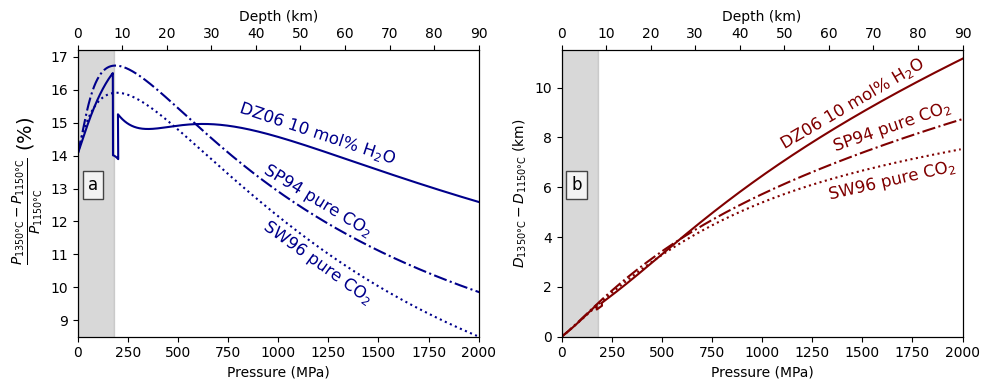

In [163]:
# Color scale for temperature curves
colors = plt.cm.hot(np.linspace(0, 0.6, len(T_K)))

dfs=[dz,sw,sp]

fig, axs = plt.subplots(1,2,figsize=(10,4))

yvar='Pressure %diff (MPa)'
xvar='Pressure (MPa)'
twinxvar='Depth (km)'
twinyvar='Depth absolute diff (km)'
#### Plot panel a ##########

min_P_ax1=0
max_P_ax1=2000 

dz_line=axs[0].plot(dz[xvar],dz[yvar],color='darkblue',linestyle='-',label='DZ06 10 mol% H$_2$O') # For guess vs 1350
sw_line=axs[0].plot(sw[xvar],sw[yvar],color='darkblue',linestyle=':',label='SW96 pure CO$_2$') # For guess vs 1350
sp_line=axs[0].plot(sp[xvar],sp[yvar],color='darkblue',linestyle='-.',label='SP94 pure CO$_2$') # For guess vs 1350

depthaxis=axs[0].twiny()
depthaxis.plot(dz[twinxvar],dz[yvar],color='none')

axs[0].set_xlim(np.round([min(dz[xvar][dz[xvar].between(min_P_ax1,max_P_ax1)]),max(dz[xvar][dz[xvar].between(min_P_ax1,max_P_ax1)])],-2))
depthaxis.set_xlim(np.round([min(dz[twinxvar][dz[xvar].between(min_P_ax1,max_P_ax1)]),max(dz[twinxvar][dz[xvar].between(min_P_ax1,max_P_ax1)])],-1))

axs[0].set_ylim(np.round([min(sw[yvar]),max(sp[yvar])+0.5],1))

axs[0].yaxis.set_major_locator(MultipleLocator(1))

axs[0].set_ylabel(r' $\frac{P_{\text{1350°C}} - P_{\text{1150°C}}}{P_{\text{1150°C}}}$ (%)',fontsize=14)
axs[0].set_xlabel('Pressure (MPa)')
depthaxis.set_xlabel('Depth (km)')

depthaxis.text(0.05, 0.50, 'a', transform=depthaxis.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)

min_P_ax2 = 0
max_P_ax2 = 180
maxsp=round(max(sp[yvar])+0.5,1)

x_coordinates = [0, max_P_ax2]
y_coordinates = [0, maxsp]
text_box_coords = [x_coordinates[0] + 50, y_coordinates[1] -5]

axs[0].fill_between(x_coordinates, 0, y_coordinates[1], color='gray', alpha=0.3)

#### Plot panel b ##########

min_P_ax1=0
max_P_ax1=2000 

dz_line_D=axs[1].plot(dz[xvar],dz[twinyvar],color='maroon',linestyle='-',label='DZ06 10 mol% H$_2$O')
sw_line_D=axs[1].plot(sw[xvar],sw[twinyvar],color='maroon',linestyle=':',label='SW96 pure CO$_2$')
sp_line_D=axs[1].plot(sp[xvar],sp[twinyvar],color='maroon',linestyle='-.',label='SP94 pure CO$_2$')

depthaxis1=axs[1].twiny()
depthaxis1.plot(dz[twinxvar],dz[yvar],color='none')

axs[1].set_xlim(np.round([min(dz[xvar][dz[xvar].between(min_P_ax1,max_P_ax1)]),max(dz[xvar][dz[xvar].between(min_P_ax1,max_P_ax1)])],-2))
depthaxis1.set_xlim(np.round([min(dz[twinxvar][dz[xvar].between(min_P_ax1,max_P_ax1)]),max(dz[twinxvar][dz[xvar].between(min_P_ax1,max_P_ax1)])],-1))

axs[1].set_ylim(np.round([min(dz[twinyvar][dz[xvar].between(min_P_ax1,max_P_ax1)]),max(dz[twinyvar][dz[xvar].between(min_P_ax1,max_P_ax1)])+0.03*max(dz[twinyvar][dz[xvar].between(min_P_ax1,max_P_ax1)])],1))

axs[1].set_ylabel(r'${D_{\text{1350°C}} - D_{\text{1150°C}}}$ (km)')

axs[1].set_xlabel('Pressure (MPa)')
depthaxis1.set_xlabel('Depth (km)')

depthaxis1.text(0.05, 0.50, 'b', transform=depthaxis1.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)

min_P_ax2 = 0
max_P_ax2 = 180
maxsp=round(max(sp[yvar])+0.5,1)

x_coordinates = [0, max_P_ax2]
y_coordinates = [0, maxsp]
text_box_coords = [x_coordinates[0] + 50, y_coordinates[1] -5]

axs[1].fill_between(x_coordinates, 0, y_coordinates[1], color='gray', alpha=0.3)

# axs[0].text(1750, 16.5, 'T = 1150 °C', ha='center', va='center',zorder=2,color = 'k')
# axs[1].text(300, 10.5, 'T = 1150 °C', ha='center', va='center',zorder=2,color = 'k')

labelLines(dz_line, zorder=3, xvals=1200, yoffsets=0.5,fontsize=12)
labelLines(sw_line, zorder=3, xvals=1200, yoffsets=-0.5,fontsize=12)
labelLines(sp_line, zorder=3, xvals=1200, yoffsets=0.5,fontsize=12)
labelLines(dz_line_D, zorder=3, xvals=1450, yoffsets=0.6,fontsize=12)
labelLines(sw_line_D, zorder=3, xvals=1650, yoffsets=-0.7,fontsize=12)
labelLines(sp_line_D, zorder=3, xvals=1650, yoffsets=0.6,fontsize=12)

fig.tight_layout()

plt.show()

plt.rcParams["pdf.fonttype"]=42
fig.savefig("FigS_Duan_SP_SW_Tcomp.pdf")



## We can also compare multiple XH2O for Duan

In [178]:
rhos=np.linspace(0.001,1.4,1000) # set range of densities for plotting later
XH2O=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]

P_values_DZ06_full = {}  # Initialize an empty dictionary to hold the values

for j in range(len(XH2O)):
    Pvals = [pf.calculate_entrapment_P_XH2O(CO2_dens_gcm3=rhos, T_K=T_K[i], XH2O=XH2O[j]) for i in range(len(T_K))]
    P_values_DZ06_full[j] = Pvals  # Assign the list of values to the dictionary using XH2O[j] as the key

P_values_DZ06_full

# # separate the mixed H2O-CO2 results, we assume H is lost as this is most likely what's measured with real samples.
# P_values_DZ06 = [df[['P_kbar_mixCO2_DZ06_Hloss', 'CO2_dens_gcm3', 'T_K','XH2O']]
#                                 .rename(columns={'P_kbar_mixCO2_DZ06_Hloss': 'P_kbar'})
#                                 .assign(**{'Pressure (MPa)': df['P_kbar_mixCO2_DZ06_Hloss'] * 100})
#                                 .reindex(columns=['P_kbar', 'Pressure (MPa)', 'CO2_dens_gcm3', 'T_K']) 
#                                 .assign(**{'Depth (km)': pf.convert_pressure_to_depth(P_kbar=df['P_kbar_mixCO2_DZ06_Hloss'], crust_dens_kgm3=2300)})
#                                 for df in P_values_XH2O10p_DZ06_full] 

{0: [     P_kbar_pureCO2_SW96  P_kbar_pureCO2_SP94  P_kbar_pureCO2_DZ06  \
  0               0.002596             0.002596             0.002596   
  1               0.006236             0.006237             0.006237   
  2               0.009883             0.009883             0.009885   
  3               0.013536             0.013534             0.013538   
  4               0.017195             0.017191             0.017197   
  ..                   ...                  ...                  ...   
  995            19.229108            20.173672            23.148442   
  996            19.287792            20.240147            23.233992   
  997            19.346648            20.306830            23.319836   
  998            19.405677            20.373721            23.405972   
  999            19.464880            20.440820            23.492402   
  
       P_kbar_mixCO2_DZ06_Hloss  P_kbar_mixCO2_DZ06_no_Hloss  \
  0                    0.002596                     0.002596   
  

In [168]:
P_values_XH2O10p_DZ06_full[1]

,P_kbar_pureCO2_SW96,P_kbar_pureCO2_SP94,P_kbar_pureCO2_DZ06,P_kbar_mixCO2_DZ06_Hloss,P_kbar_mixCO2_DZ06_no_Hloss,P Mix_Hloss/P Pure DZ06,P Mix_no_Hloss/P Pure DZ06,rho_mix_calc_Hloss,rho_mix_calc_noHloss,CO2_dens_gcm3,T_K,XH2O
0,0.002690,0.002691,0.002691,0.002990,0.002996,1.111043,1.113291,0.001045,0.001048,0.001000,1423.15,0.1
1,0.006464,0.006464,0.006465,0.007182,0.007196,1.110948,1.113123,0.002510,0.002514,0.002400,1423.15,0.1
2,0.010244,0.010243,0.010245,0.011381,0.011402,1.110854,1.112956,0.003974,0.003981,0.003801,1423.15,0.1
3,0.014030,0.014028,0.014032,0.015586,0.015615,1.110763,1.112791,0.005438,0.005448,0.005201,1423.15,0.1
4,0.017824,0.017819,0.017826,0.019798,0.019833,1.110674,1.112628,0.006902,0.006914,0.006602,1423.15,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,19.673513,20.689511,23.887700,30.671120,25.045309,1.283971,1.048460,1.457780,1.380277,1.394398,1423.15,0.1
996,19.732771,20.756947,23.975061,30.787626,25.135036,1.284152,1.048383,1.459244,1.381633,1.395799,1423.15,0.1
997,19.792202,20.824591,24.062716,30.904529,25.225064,1.284333,1.048305,1.460708,1.382989,1.397199,1423.15,0.1
998,19.851806,20.892444,24.150668,31.021831,25.315395,1.284512,1.048228,1.462172,1.384346,1.398600,1423.15,0.1


In [ ]:
# separate the mixed H2O-CO2 results, we assume H is lost as this is most likely what's measured with real samples.
P_values_DZ06 = [df[['P_kbar_mixCO2_DZ06_Hloss', 'CO2_dens_gcm3', 'T_K','XH2O']]
                                .rename(columns={'P_kbar_mixCO2_DZ06_Hloss': 'P_kbar'})
                                .assign(**{'Pressure (MPa)': df['P_kbar_mixCO2_DZ06_Hloss'] * 100})
                                .reindex(columns=['P_kbar', 'Pressure (MPa)', 'CO2_dens_gcm3', 'T_K']) 
                                .assign(**{'Depth (km)': pf.convert_pressure_to_depth(P_kbar=df['P_kbar_mixCO2_DZ06_Hloss'], crust_dens_kgm3=2300)})
                                for df in P_values_XH2O10p_DZ06_full] 

## Original single panel comparison Fig

c:\Users\charl\anaconda3\envs\py3115\Lib\site-packages\labellines\core.py:151: UserWarning: Tried to label line Line2D(_child0), but could not find a label for it.
  warnings.warn(


Text(1800, 16.8, 'T = 1150 °C')

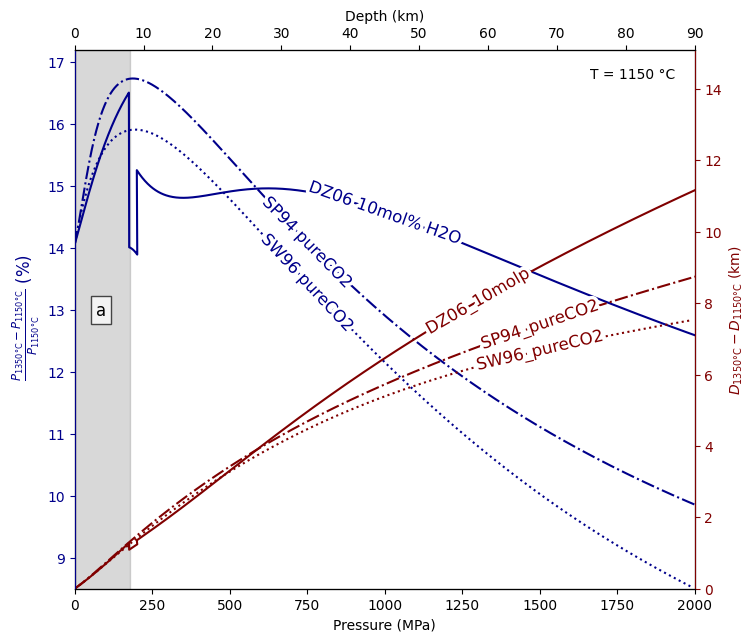

In [129]:
# Color scale for temperature curves
colors = plt.cm.hot(np.linspace(0, 0.6, len(T_K)))

dfs=[dz,sw,sp]

fig, ((ax5)) = plt.subplots(1,1,figsize=(8,7))

yvar='Pressure %diff (MPa)'
xvar='Pressure (MPa)'
twinxvar='Depth (km)'
twinyvar='Depth absolute diff (km)'
#### Plot panel a ##########

min_P_ax1=0
max_P_ax1=2000 

ax5.plot(dz[xvar],dz[yvar],color='darkblue',linestyle='-',label='DZ06 10mol% H2O') # For guess vs 1350
ax5.plot(sw[xvar],sw[yvar],color='darkblue',linestyle=':',label='SW96 pureCO2') # For guess vs 1350
ax5.plot(sp[xvar],sp[yvar],color='darkblue',linestyle='-.',label='SP94 pureCO2') # For guess vs 1350

labelLines(ax5.get_lines(), zorder=3, xvals=[1000,750,750], fontsize=12)

ax6=ax5.twinx()
ax6.plot(dz[xvar],dz[yvar],color='none')

ax6.plot(dz[xvar],dz[twinyvar],color='maroon',linestyle='-',label='DZ06_10molp')
ax6.plot(sw[xvar],sw[twinyvar],color='maroon',linestyle=':',label='SW96_pureCO2')
ax6.plot(sp[xvar],sp[twinyvar],color='maroon',linestyle='-.',label='SP94_pureCO2')

labelLines(ax6.get_lines(), zorder=3, xvals=[1300,1500,1500], fontsize=12)


ax7=ax5.twiny()
ax7.plot(dz[twinxvar],dz[yvar],color='none')

ax5.set_xlim(np.round([min(dz[xvar][dz[xvar].between(min_P_ax1,max_P_ax1)]),max(dz[xvar][dz[xvar].between(min_P_ax1,max_P_ax1)])],-2))
ax7.set_xlim(np.round([min(dz[twinxvar][dz[xvar].between(min_P_ax1,max_P_ax1)]),max(dz[twinxvar][dz[xvar].between(min_P_ax1,max_P_ax1)])],-1))

ax5.set_ylim(np.round([min(sw[yvar]),max(sp[yvar])+0.5],1))
ax6.set_ylim(np.round([min(dz[twinyvar]),max(dz[twinyvar])],1))

ax5.yaxis.set_major_locator(MultipleLocator(1))

ax6.set_ylabel(r'${D_{\text{1350°C}} - D_{\text{1150°C}}}$ (km)',color='maroon')
ax5.set_ylabel(r' $\frac{P_{\text{1350°C}} - P_{\text{1150°C}}}{P_{\text{1150°C}}}$ (%)',color='darkblue',fontsize=12)
ax5.set_xlabel('Pressure (MPa)')
ax7.set_xlabel('Depth (km)')

ax6.tick_params(axis='y', color='maroon',labelcolor='maroon')
ax7.spines['right'].set_color('maroon')

ax5.tick_params(axis='y', color='darkblue',labelcolor='darkblue')
ax7.spines['left'].set_color('darkblue')

ax7.text(0.05, 0.50, 'a', transform=ax7.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)

min_P_ax2 = 0
max_P_ax2 = 180
maxsp=round(max(sp[yvar])+0.5,1)

x_coordinates = [0, max_P_ax2]
y_coordinates = [0, maxsp]
text_box_coords = [x_coordinates[0] + 50, y_coordinates[1] -5]

ax5.fill_between(x_coordinates, 0, y_coordinates[1], color='gray', alpha=0.3)

ax5.text(1800, 16.8, 'T = 1150 °C', ha='center', va='center',zorder=2,color = 'k')

# fig.savefig("FigS_Duan_SP_SW_Tcomp.pdf")

